In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [69]:
df=pd.read_csv('drive/MyDrive/lab4/Vietcombank.csv')
df
df1=df.reset_index()['Close']

In [70]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,21529.789062,21628.097656,20939.931641,21234.859375,21234.859375,1549694
1,2016-01-05,21087.396484,21333.169922,20841.621094,20890.777344,20890.777344,2305491
2,2016-01-06,20890.777344,21234.859375,20890.777344,21136.550781,21136.550781,1616259
3,2016-01-07,21038.240234,21087.396484,20645.003906,20890.777344,20890.777344,1903089
4,2016-01-08,20792.466797,20939.931641,20497.539062,20743.312500,20743.312500,1375938
...,...,...,...,...,...,...,...
2038,2024-03-14,96000.000000,96100.000000,94600.000000,95000.000000,95000.000000,2347601
2039,2024-03-15,95000.000000,95000.000000,93900.000000,94000.000000,94000.000000,2466500
2040,2024-03-18,94300.000000,94500.000000,92500.000000,93000.000000,93000.000000,1867500
2041,2024-03-19,92500.000000,93500.000000,92500.000000,92500.000000,92500.000000,1060100


In [71]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [72]:
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [73]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [74]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [75]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(1737, 100)
(1737,)
(104, 100)
(104,)


In [76]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [77]:
kf = kf.em(X_train[0])

In [78]:
test_data.shape

(205, 1)

In [79]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [80]:
test_predicted.shape

(205, 1)

In [81]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [82]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [83]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 2806.3785782592954
Testing MAPE: 0.8807127719897709
Testing MAE: 559.7348547050444


In [84]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

145

In [85]:
test_data[60:].shape

(145, 1)

In [86]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

(1, 145)
[0.35089603]
146
1 day input [0.89926843 0.90309368 0.88524252 0.85846577 0.86739136 0.85719069
 0.86739136 0.88524252 0.8941681  0.8941681  0.90691893 0.90819402
 0.89926843 0.89926843 0.8865176  0.90436877 0.8941681  0.8941681
 0.90309368 0.89034285 0.88141727 0.88014219 0.86739136 0.89671827
 0.89671827 0.86739136 0.87759202 0.88014219 0.87376677 0.86101594
 0.85846577 0.85846577 0.83551428 0.84699003 0.83678936 0.85591561
 0.86101594 0.85464052 0.86229102 0.85591561 0.85336544 0.85336544
 0.83551428 0.83933953 0.83551428 0.85464052 0.85209036 0.83551428
 0.84188969 0.85336544 0.86484119 0.87759202 0.89289302 0.89161793
 0.89926843 0.88396744 0.89926843 0.8788671  0.85464052 0.84826511
 0.85464052 0.87631694 0.88014219 0.84954019 0.85591561 0.86229102
 0.86356611 0.84826511 0.85464052 0.85209036 0.85209036 0.84316478
 0.83806444 0.84188969 0.85464052 0.84699003 0.85336544 0.84443986
 0.84188969 0.83168903 0.83168903 0.82531361 0.80618737 0.79726178
 0.79343653 0.79216145 0.

In [87]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

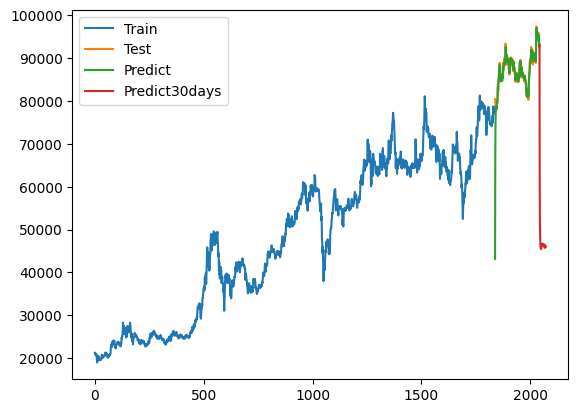

In [88]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

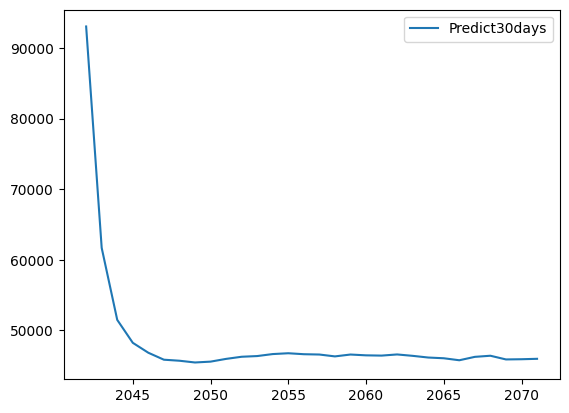

In [89]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Predict30days'])
plt.show()